In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz as avz
from sklearn.model_selection import train_test_split
import statsmodels.graphics as smg
import patsy
from matplotlib.gridspec import GridSpec
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import scipy.stats as stats
import numpy as np
from statsmodels.stats.multitest import multipletests

from itertools import product
warnings.filterwarnings('ignore')

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

# Research Question 1

In [2]:
df1= pd.read_csv("df_q1.csv")

# More preprocessing

## Some more EDA for df1  
1. remove the rows with hospitalized rate == 0.0  
2. one hotencoding for column "state" and "season"
3. filter out the rows with the outliers of log(y)
4. select the features we need. May consider the model selection with removeing some features

In [3]:
#1. remove the rows with hospitalized rate == 0.0 
df1 = df1[df1["hospitalized_rate"] !=0.0]
df1["log_hospitalized_rate"] = np.log(df1["hospitalized_rate"])

#2. one hotencoding for column "state" and "season"
#one hotencoding for "state"
state_ohe = pd.get_dummies(df1["state"])
#one hotencoding for "season"
season_ohe = pd.get_dummies(df1["season"])
df1 = pd.concat([df1,state_ohe,season_ohe], axis=1)

#3. filter out the rows with the describeers of log(y), and the mobility features
#remove the rows with log_y <=1
df1 = df1[(df1["log_hospitalized_rate"]>=1) &
          (df1["gps_retail_and_recreation"]>=df1["gps_retail_and_recreation"].quantile(0.1)) & 
          (df1["gps_retail_and_recreation"]<=df1["gps_retail_and_recreation"].quantile(0.9))&
          (df1["gps_grocery_and_pharmacy"]>=df1["gps_grocery_and_pharmacy"].quantile(0.1))&
          (df1["gps_grocery_and_pharmacy"]<=df1["gps_grocery_and_pharmacy"].quantile(0.9))&
          (df1["gps_parks"]>=df1["gps_parks"].quantile(0.1)) &
          (df1["gps_parks"]<=df1["gps_parks"].quantile(0.9)) &
           (df1["gps_transit_stations"]>=df1["gps_transit_stations"].quantile(0.1)) & 
          (df1["gps_transit_stations"]<=df1["gps_transit_stations"].quantile(0.9))&
           (df1["gps_workplaces"]>=df1["gps_workplaces"].quantile(0.1)) & 
          (df1["gps_workplaces"]<=df1["gps_workplaces"].quantile(0.9)) &
           (df1["gps_residential"]>=df1["gps_residential"].quantile(0.1)) & 
          (df1["gps_residential"]<=df1["gps_residential"].quantile(0.9))&
           (df1["gps_away_from_home"]>=df1["gps_away_from_home"].quantile(0.1)) & 
          (df1["gps_away_from_home"]<=df1["gps_away_from_home"].quantile(0.9))]
df1.head()

,date,state,hospitalized_rate,year,month,day,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_parks,gps_transit_stations,...,gps_away_from_home,season,log_hospitalized_rate,CA,NY,TX,Autumn,Spring,Summer,Winter
199,2020-05-10,TX,6.94,2020,5,10,-0.220,-0.0114,0.02000,-0.329,...,-0.157,Spring,1.937302,0,0,1,0,1,0,0
202,2020-05-11,TX,7.17,2020,5,11,-0.217,-0.0129,0.03000,-0.326,...,-0.156,Spring,1.969906,0,0,1,0,1,0,0
205,2020-05-12,TX,7.63,2020,5,12,-0.219,-0.0171,0.01710,-0.326,...,-0.156,Spring,2.032088,0,0,1,0,1,0,0
208,2020-05-13,TX,8.12,2020,5,13,-0.216,-0.0171,0.01000,-0.324,...,-0.156,Spring,2.094330,0,0,1,0,1,0,0
211,2020-05-14,TX,8.65,2020,5,14,-0.213,-0.0186,0.00857,-0.324,...,-0.156,Spring,2.157559,0,0,1,0,1,0,0


In [4]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Visualization the result

<AxesSubplot:xlabel='log_hospitalized_rate', ylabel='Density'>

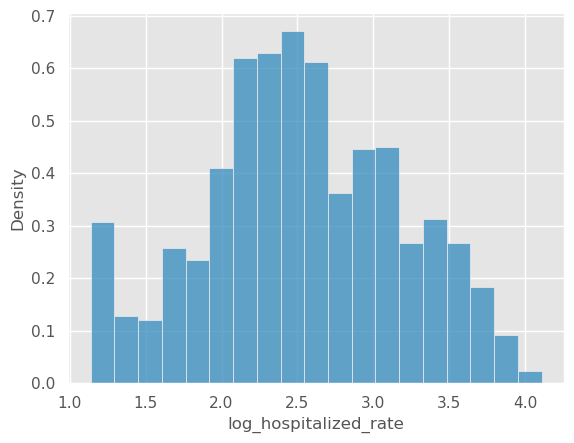

In [5]:
# the plot of 
sns.histplot(df1["log_hospitalized_rate"],stat="density")

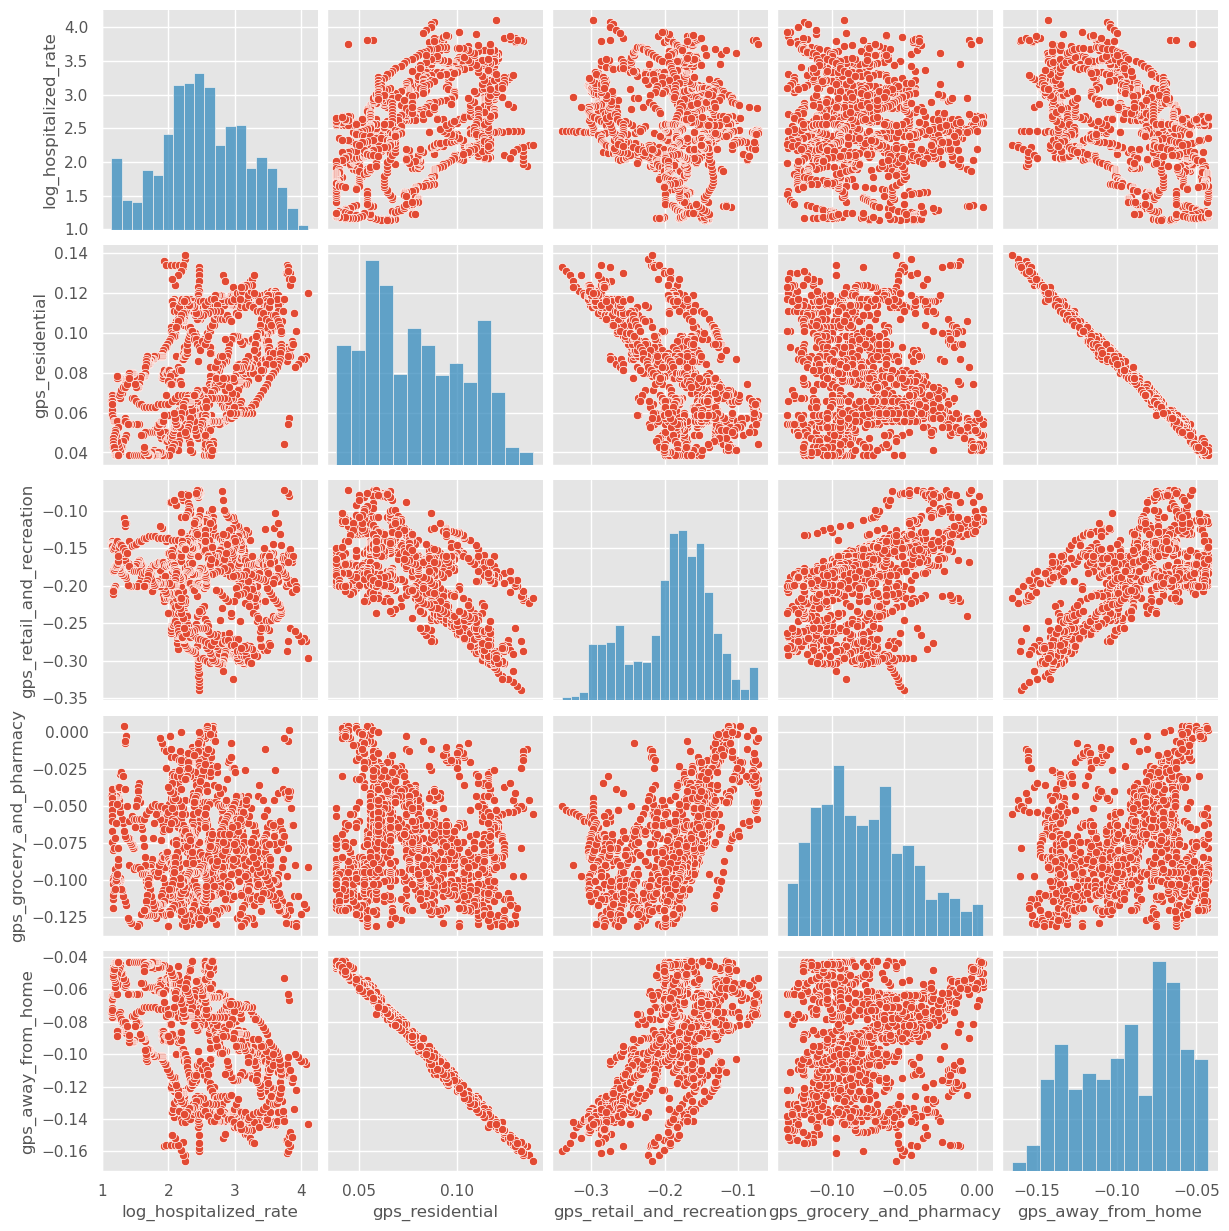

In [6]:
sns.pairplot(data=df1,
             vars=['log_hospitalized_rate', 'gps_residential', 'gps_retail_and_recreation',
                   'gps_grocery_and_pharmacy', 'gps_away_from_home'],
             diag_kind='hist')

In [7]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Some helper functions

In [8]:
#4. select the features we need. May consider the model selection with removeing some features
#choose all one hotencoding variables, but actually not necessary.
#use function construct_df() to choose the features and response variables
def construct_df(df, feature_arr, response_arr):
    arr_combined = pd.concat([pd.Series(response_arr), pd.Series(feature_arr)]).values
    result_df = df[arr_combined]
    result_df = result_df.reset_index().drop('index', axis=1)
    return result_df

In [9]:
#split the data into train and test ,set seed as 102
#get y and X, add constant to X
#df_split()
def df_split(df):
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=102)
    y_train = train_data[["log_hospitalized_rate"]]
    X_train = train_data.drop("log_hospitalized_rate",axis=1)
    y_test = test_data[["log_hospitalized_rate"]]
    X_test = test_data.drop("log_hospitalized_rate",axis=1)
    # X_train = sm.add_constant(X_train)
    # X_test = sm.add_constant(X_test)
    return X_train, y_train, X_test, y_test

In [10]:
#check model accuracy with RMSE for test df
def get_RMSE(df_y, y, prediction):
    if y == 'log_hospitalized_rate' :
        result = np.mean((np.exp(df_y[y])- np.exp(prediction))**2)
    if y =='hospitalized_rate':
        result = np.mean((df_y[y] - prediction)**2)
    return np.sqrt(result)

In [11]:
%%latex
\newpage

<IPython.core.display.Latex object>

# Buliding different model

## Non-parametric Models

### Decision Tree

In [12]:
df = df1.copy()
df = df.drop(['date','state','log_hospitalized_rate','season'], axis=1)
X = df.drop(['hospitalized_rate'], axis=1)
y = df['hospitalized_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

for i in range(3, 21):
    model_dt = DecisionTreeRegressor(max_depth=i, random_state=102)
    model_dt.fit(X_train, y_train)
    y_pred = model_dt.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Max Depth: {i}, MSE: {mse}")

Max Depth: 3, MSE: 40.823511735731394
Max Depth: 4, MSE: 27.333956340896666
Max Depth: 5, MSE: 23.065091919855217
Max Depth: 6, MSE: 15.841064263809985
Max Depth: 7, MSE: 9.73410232990186
Max Depth: 8, MSE: 7.785169364587245
Max Depth: 9, MSE: 5.306332372410726
Max Depth: 10, MSE: 5.1316690671198995
Max Depth: 11, MSE: 4.8447534446438025
Max Depth: 12, MSE: 4.628948845209315
Max Depth: 13, MSE: 4.726580532815765
Max Depth: 14, MSE: 5.010887539330077
Max Depth: 15, MSE: 5.808280869873667
Max Depth: 16, MSE: 5.9557494611861665
Max Depth: 17, MSE: 4.799103647827337
Max Depth: 18, MSE: 4.587310862296598
Max Depth: 19, MSE: 5.765944051274393
Max Depth: 20, MSE: 5.626142741935484


In [13]:
#Thus, we need to choose max depth 18, since it has smallest mse
#but I am using max depth of 10, since I really need good interpretability
model_dt = DecisionTreeRegressor(max_depth=10, random_state=102)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=102)

In [14]:
y_pred = model_dt.predict(X_test)
y_pred_dt = y_pred.copy()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse_dt = rmse.copy()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 5.1316690671198995
Root Mean Squared Error (RMSE): 2.265318756184193
Mean Absolute Error (MAE): 1.1471342405304255
R-squared (R2): 0.9537815135515909


In [15]:
%%latex
\newpage

<IPython.core.display.Latex object>

### Visualizations

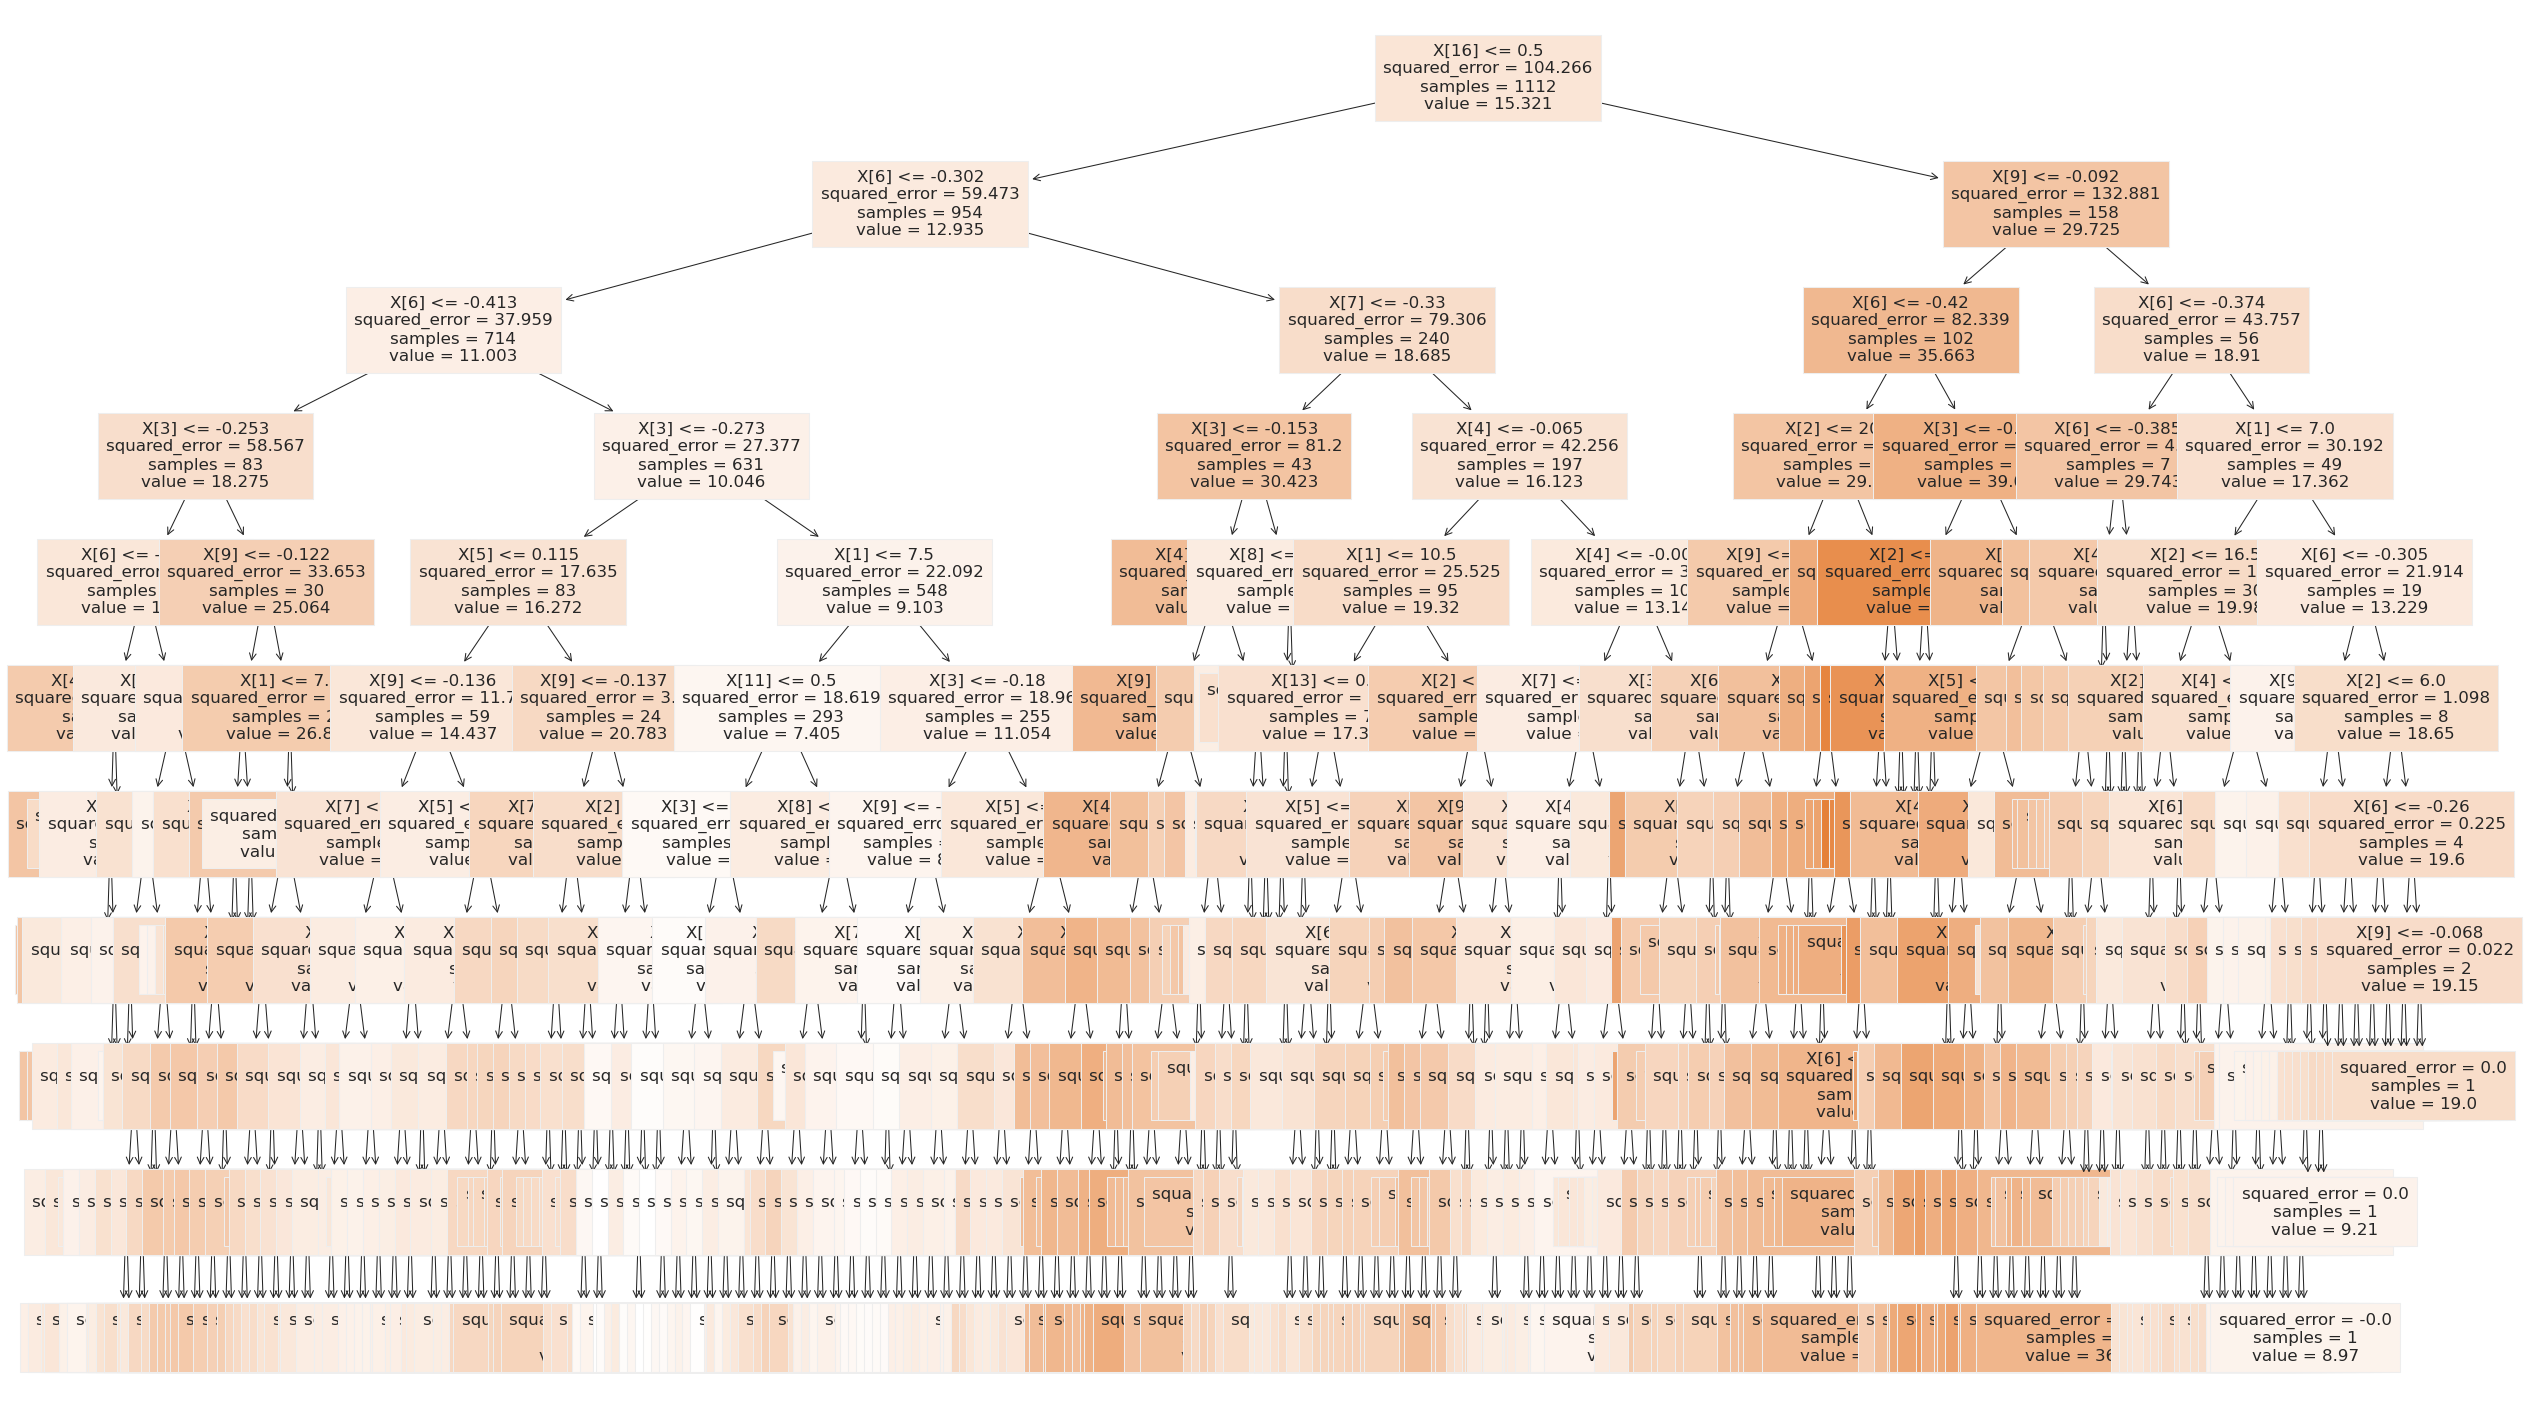

In [16]:
plt.figure(figsize=(20, 12), dpi=150)
plot_tree(model_dt, filled=True, fontsize=8)
plt.show()

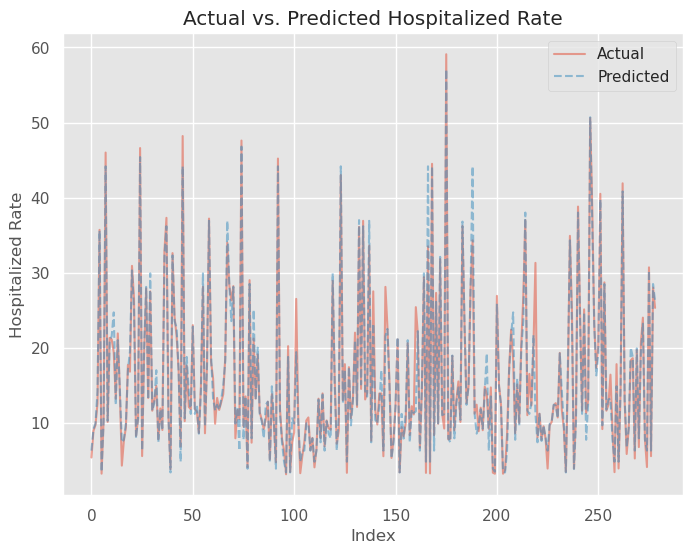

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_test)), y_test, label='Actual', alpha = 0.5)
plt.plot(range(len(y_test)), y_pred, label='Predicted', linestyle='--', alpha = 0.5)
plt.xlabel('Index')
plt.ylabel('Hospitalized Rate')
plt.title('Actual vs. Predicted Hospitalized Rate')
plt.legend()
plt.show()

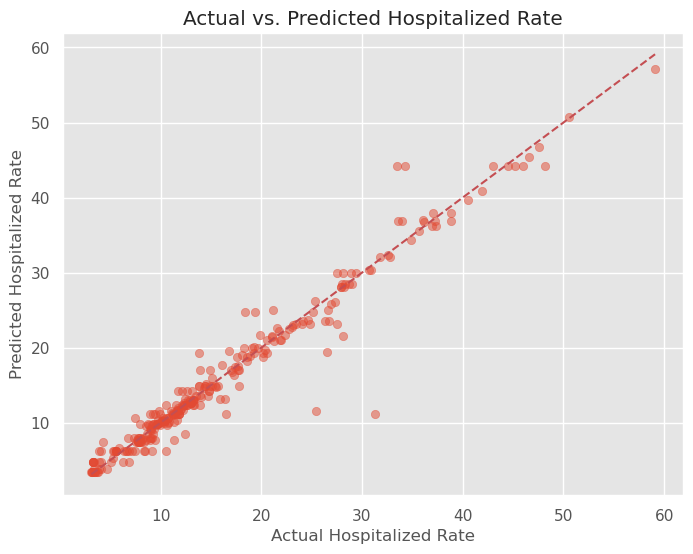

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Hospitalized Rate')
plt.ylabel('Predicted Hospitalized Rate')
plt.title('Actual vs. Predicted Hospitalized Rate')
plt.show()

In [19]:
%%latex
\newpage

<IPython.core.display.Latex object>

### Random Forest

In [20]:
n_estimators = 120
max_features = [4, 8, 10]
max_depths = [None, 3, 5, 10, 15]
for f, d in product(max_features, max_depths):
    model_rf = RandomForestRegressor(n_estimators=n_estimators, 
                                  max_depth=d, 
                                  max_features=f, 
                                  random_state=102)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Max Depth: {d}, Max Feature: {f}, MSE: {mse}")

Max Depth: None, Max Feature: 4, MSE: 3.6122001051871773
Max Depth: 3, Max Feature: 4, MSE: 35.9082647100671
Max Depth: 5, Max Feature: 4, MSE: 16.183028597523005
Max Depth: 10, Max Feature: 4, MSE: 3.708292560455304
Max Depth: 15, Max Feature: 4, MSE: 3.8627318304701146
Max Depth: None, Max Feature: 8, MSE: 3.4279463574522078
Max Depth: 3, Max Feature: 8, MSE: 33.304052700118284
Max Depth: 5, Max Feature: 8, MSE: 13.826908265854037
Max Depth: 10, Max Feature: 8, MSE: 3.948871587763171
Max Depth: 15, Max Feature: 8, MSE: 3.7190591250462197
Max Depth: None, Max Feature: 10, MSE: 3.382033490118476
Max Depth: 3, Max Feature: 10, MSE: 32.06474257987359
Max Depth: 5, Max Feature: 10, MSE: 13.827968864605843
Max Depth: 10, Max Feature: 10, MSE: 3.868530231022025
Max Depth: 15, Max Feature: 10, MSE: 3.4216865107705154


In [21]:
#So we choose Max Depth of 10, and max features of 4
model_rf = RandomForestRegressor(n_estimators=n_estimators, 
                                  max_depth=10, 
                                  max_features=4, 
                                  random_state=102)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
y_pred_rf = y_pred.copy()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse_rf = rmse.copy()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 3.708292560455304
Root Mean Squared Error (RMSE): 1.9256927481961665
Mean Absolute Error (MAE): 1.170719817056627
R-squared (R2): 0.9666011842910338


### Visualizations

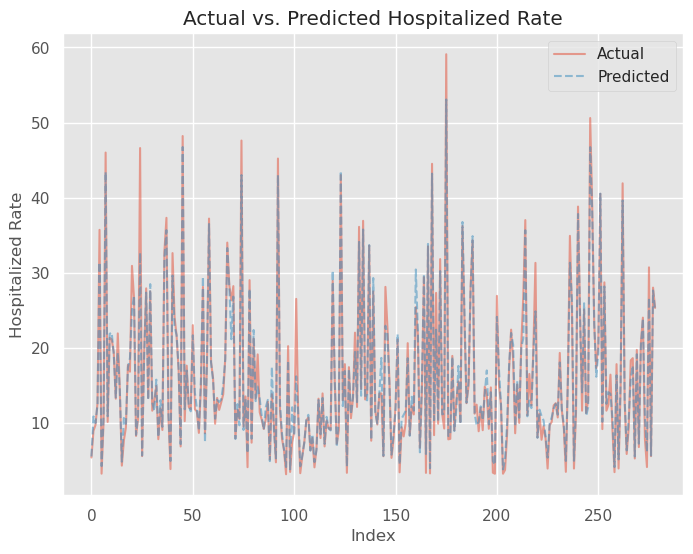

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_test)), y_test, label='Actual', alpha = 0.5)
plt.plot(range(len(y_test)), y_pred, label='Predicted', linestyle='--', alpha = 0.5)
plt.xlabel('Index')
plt.ylabel('Hospitalized Rate')
plt.title('Actual vs. Predicted Hospitalized Rate')
plt.legend()
plt.show()

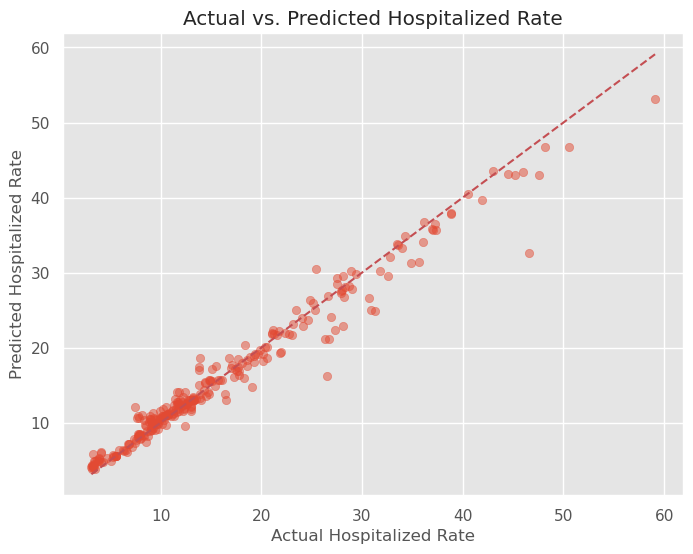

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Hospitalized Rate')
plt.ylabel('Predicted Hospitalized Rate')
plt.title('Actual vs. Predicted Hospitalized Rate')
plt.show()

In [24]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Frequentist Model 
### with normal likelihood with full model with log hospitalized rate

In [25]:
data = df1.drop(columns=["date", "state", "hospitalized_rate", "year","month", "day","CA","Spring","season"])
X_train, y_train, X_test, y_test = df_split(df= data)

In [26]:
#full model with log hospitalized rate

gaussian_model_intercept_1 = sm.GLM(
    y_train, sm.add_constant(X_train),                
    family=sm.families.Gaussian()
)
gaussian_results_1 = gaussian_model_intercept_1.fit()
print(gaussian_results_1.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     log_hospitalized_rate   No. Observations:                 1112
Model:                               GLM   Df Residuals:                     1099
Model Family:                   Gaussian   Df Model:                           12
Link Function:                  identity   Scale:                         0.17732
Method:                             IRLS   Log-Likelihood:                -609.55
Date:                   Mon, 08 May 2023   Deviance:                       194.87
Time:                           22:34:18   Pearson chi2:                     195.
No. Iterations:                        3   Pseudo R-squ. (CS):             0.7570
Covariance Type:               nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [27]:
gaussian_results_1.params

const                         1.310234
gps_retail_and_recreation     1.967904
gps_grocery_and_pharmacy     -2.420846
gps_parks                    -0.303406
gps_transit_stations         -0.554715
gps_workplaces               -1.282132
gps_residential             -93.697349
gps_away_from_home          -83.241056
NY                            0.645027
TX                            0.566630
Autumn                        0.294488
Summer                        0.373722
Winter                        0.743887
dtype: float64

In [28]:
prediction_train= gaussian_results_1.predict(sm.add_constant(X_train))
np.sqrt(np.mean(((np.exp(prediction_train) - np.exp(y_train["log_hospitalized_rate"]))**2)))

6.668888965856322

### Uncertainty Quantification for Frequentist Model with Confidence Intervals

In [29]:
frequentist_df = gaussian_results_1.conf_int()
frequentist_df["coef"] = gaussian_results_1.params
frequentist_df = frequentist_df.rename(columns={0: "CI_lower", 1: "CI_upper"})
frequentist_df = frequentist_df[["coef", "CI_lower", "CI_upper"]]
frequentist_df

,coef,CI_lower,CI_upper
const,1.310234,0.978903,1.641564
gps_retail_and_recreation,1.967904,0.676890,3.258919
gps_grocery_and_pharmacy,-2.420846,-3.959824,-0.881869
gps_parks,-0.303406,-0.593012,-0.013799
gps_transit_stations,-0.554715,-1.509518,0.400088
gps_workplaces,-1.282132,-2.469518,-0.094745
gps_residential,-93.697349,-112.888198,-74.506501
gps_away_from_home,-83.241056,-98.431341,-68.050770
NY,0.645027,0.557096,0.732958
TX,0.566630,0.394857,0.738404


### check model accuracy with RMSE for test df
#### Note: The RMSE is based on the hospitalized rate instead of the log one

In [30]:
prediction_1 = gaussian_results_1.predict(sm.add_constant(X_test))
rmse_frequentist = get_RMSE(y_test,'log_hospitalized_rate', prediction_1)
rmse_frequentist

6.326716986572554

In [31]:
%%latex
\newpage

<IPython.core.display.Latex object>

### Visualize the the observed value and the predition of log hospitalized rate in test set

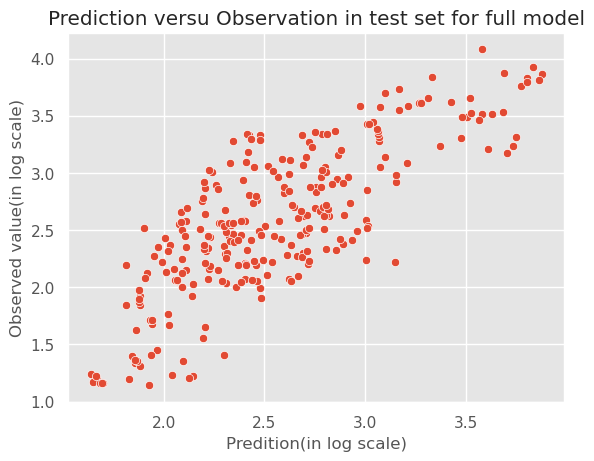

In [32]:
sns.scatterplot(y= y_test["log_hospitalized_rate"], x = prediction_1)
plt.xlabel("Predition(in log scale)")
plt.ylabel("Observed value(in log scale)")
plt.title("Prediction versu Observation in test set for full model");

In [33]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Bayesian model
### We would construct the prior for some parameters based on the understanding from the result of frequentist model

In [34]:
trainx, trainy, testx, testy = X_train, y_train, X_test, y_test

trainx_res_awh = trainx[['gps_residential',
                                                                      'gps_away_from_home']]
trainx_others = trainx[['gps_retail_and_recreation', 'gps_grocery_and_pharmacy', 'gps_parks',
                                                                     'gps_transit_stations', 'gps_workplaces', 'NY', 'TX', 'Autumn','Summer', 'Winter']]

testx_res_awh = testx[['gps_residential',
                                                                      'gps_away_from_home']]
testx_others = testx[['gps_retail_and_recreation', 'gps_grocery_and_pharmacy', 'gps_parks',
                                                                     'gps_transit_stations', 'gps_workplaces', 'NY', 'TX', 'Autumn','Summer', 'Winter']]

In [35]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu = 1, sd =10)
    betas_res_awh = pm.Normal('beta_res_wah', mu=-90, sd=1000, shape=2)
    betas_others = pm.Normal('beta_other', mu=0, sd=5, shape=10)
    sigma = pm.HalfNormal('sigma', sd=1000)
    
    xdata1 = pm.Data("pred1", trainx_res_awh.T)
    xdata2 = pm.Data("pred2", trainx_others.T)
    
    mu = alpha + pm.math.dot(betas_res_awh, xdata1)+pm.math.dot(betas_others, xdata2)
    
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=np.array(trainy).reshape(-1))
    
    trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_other, beta_res_wah, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 106 seconds.


In [36]:
posterior_predictive = pm.sample_posterior_predictive(trace, model=bglm, samples=500)

# Extract the posterior samples of y
posterior_y = posterior_predictive['y']

# Print the posterior mean of y
prediction_train = posterior_y.mean(0)

In [37]:
np.sqrt(np.mean(((np.exp(prediction_train) - np.exp(y_train["log_hospitalized_rate"]))**2)))

6.685276631661283

In [38]:
with bglm:
    pm.set_data({"pred1": testx_res_awh.T, "pred2": testx_others.T })
    
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"], samples=600)
    model_preds = posterior_predictive["y"]

In [39]:
alpha = 1-0.5
pred_df =pd.DataFrame({"log_hospitalized_rate":testy.reset_index(drop=True)["log_hospitalized_rate"].copy(),
                      "pred_mean":model_preds.mean(0),
                      "CI_lower":avz.hdi(model_preds,alpha)[:,0],
                      "CI_upper":avz.hdi(model_preds,alpha)[:,1]})
rate = sum((pred_df["log_hospitalized_rate"]>=pred_df["CI_lower"])&(pred_df["log_hospitalized_rate"]<=pred_df["CI_upper"]))  / pred_df.shape[0]
ori_model_preds = np.exp(model_preds)
pred_df1 =pd.DataFrame({"hospitalized_rate":np.exp(testy.reset_index(drop=True)["log_hospitalized_rate"].copy()),
                      "pred_mean":ori_model_preds.mean(0),
                      "CI_lower":avz.hdi(ori_model_preds,alpha)[:,0],
                      "CI_upper":avz.hdi(ori_model_preds,alpha)[:,1]})

In [40]:
%%latex
\newpage

<IPython.core.display.Latex object>

### Uncertainty Quantification for Bayesian Model's Predictions with Credible Intervals

In [41]:
pred_df.head()

,log_hospitalized_rate,pred_mean,CI_lower,CI_upper
0,1.678964,1.968505,1.734270,2.325802
1,2.187174,2.239932,1.948212,2.472498
2,2.271094,2.656430,2.350256,2.909983
3,2.533697,2.488457,2.209930,2.734234
4,3.575151,3.069890,2.836673,3.336269


### Visualize the prediction, Observation, and the credible interval (In log scale).

#### Note: since we believe the likelihood of log hospitalized rate is normal, we choose the mean the each PPD as the representation of prediction

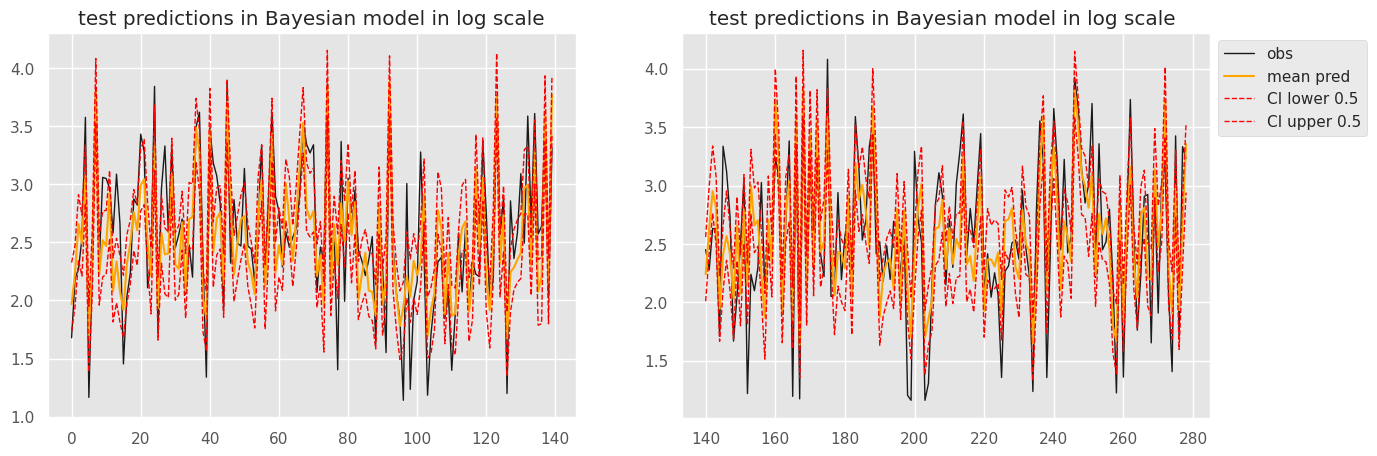

In [42]:
fig=plt.figure(figsize=(15,5))
gs=GridSpec(nrows=1,ncols=2,width_ratios=[1,1]) # 2 rows, 3 columns

ax0 = fig.add_subplot(gs[0])
ax0.set_title("test predictions in Bayesian model in log scale")
ax0.plot(pred_df["log_hospitalized_rate"][:140],'k-',lw=1,label='obs')
ax0.plot(pred_df["pred_mean"][:140],c='orange',label='mean pred')
alpha = 1-0.5
ax0.plot(pred_df["CI_lower"][:140],ls='--',lw=1,c='red',label=f'CI lower {alpha}')
ax0.plot(pred_df["CI_upper"][:140],ls='--',lw=1,c='red',label=f'CI upper {alpha}')


ax1 = fig.add_subplot(gs[1])
ax1.set_title("test predictions in Bayesian model in log scale ")
ax1.plot(pred_df["log_hospitalized_rate"][140:],'k-',lw=1,label='obs')
ax1.plot(pred_df["pred_mean"][140:],c='orange',label='mean pred')
alpha = 1-0.5
ax1.plot(pred_df["CI_lower"][140:],ls='--',lw=1,c='red',label=f'CI lower {alpha}')
ax1.plot(pred_df["CI_upper"][140:],ls='--',lw=1,c='red',label=f'CI upper {alpha}')


ax1.legend(bbox_to_anchor=(1,1));

In [43]:
%%latex
\newpage

<IPython.core.display.Latex object>

### Visualize relationship bwtween the prediction and the observations in test set (In log scale)

Text(0.5, 1.0, 'Prediction versu Observation in test set for Bayesian model')

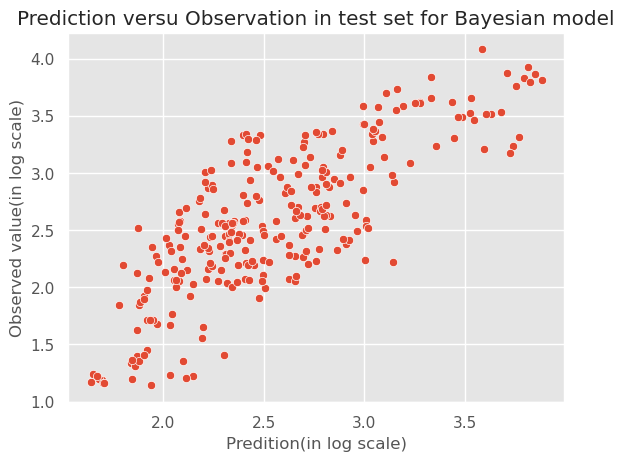

In [44]:
sns.scatterplot(y= testy.reset_index(drop=True)["log_hospitalized_rate"], x = model_preds.mean(0))
plt.xlabel("Predition(in log scale)")
plt.ylabel("Observed value(in log scale)")
plt.title("Prediction versu Observation in test set for Bayesian model")

### check model accuracy with RMSE for test df
#### Note: The RMSE is based on the hospitalized rate instead of the log one

In [45]:
rmse_bayesian = get_RMSE(df_y=pred_df1, y='hospitalized_rate', prediction=pred_df1["pred_mean"])
rmse_bayesian

6.3018315977440995

### Visualize the PPD for coefficient and its credible interval .

array([[<AxesSubplot:title={'center':'beta_res_wah'}>,
        <AxesSubplot:title={'center':'beta_res_wah'}>]], dtype=object)

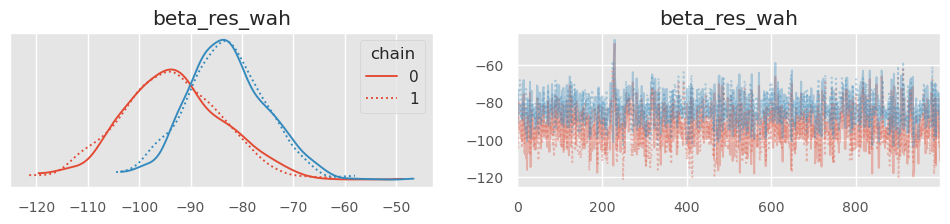

In [46]:
avz.plot_trace(trace, var_names=['beta_res_wah'],legend=True)

array([[<AxesSubplot:title={'center':'beta_other'}>,
        <AxesSubplot:title={'center':'beta_other'}>]], dtype=object)

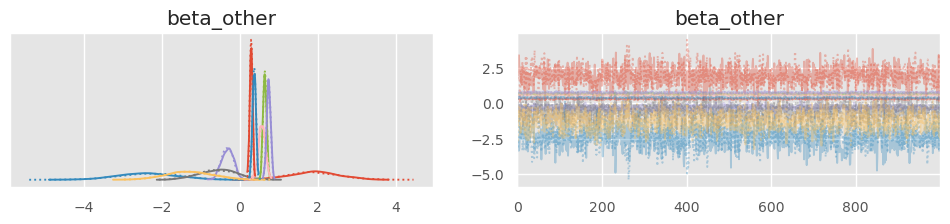

In [47]:
avz.plot_trace(trace, var_names=['beta_other'])

In [48]:
%%latex
\newpage

<IPython.core.display.Latex object>

### Uncertainty Quantification for Bayesian Model's parameters with Credible Intervals

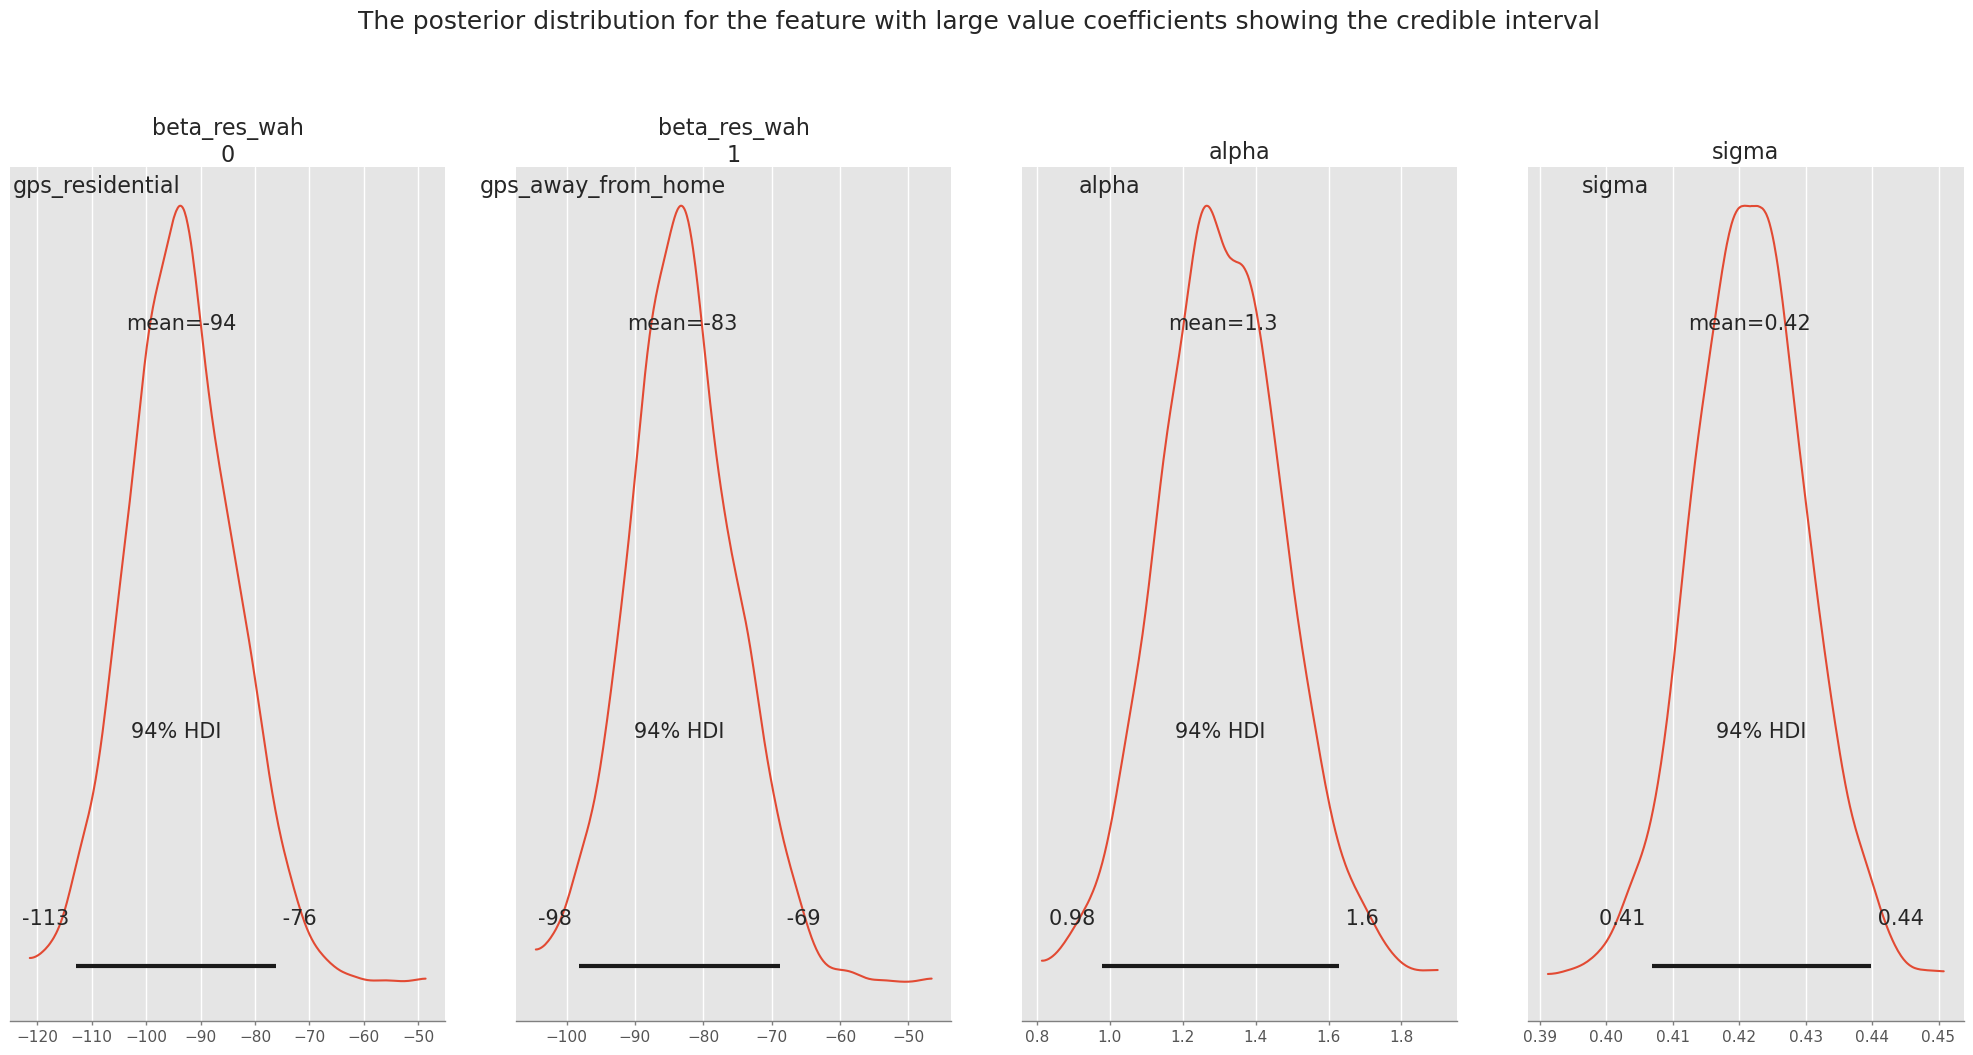

In [49]:
axes = avz.plot_posterior(trace, var_names=['beta_res_wah','alpha', 'sigma'], kind='kde', figsize=(20,10))

# Set the subplot titles
titles = ['gps_residential','gps_away_from_home','alpha', 'sigma']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.2, 0.99, titles[i], transform=ax.transAxes, ha='center', va='top',fontsize=16)
plt.suptitle("The posterior distribution for the feature with large value coefficients showing the credible interval", fontsize=18, y=1.05)

plt.tight_layout()
plt.show()

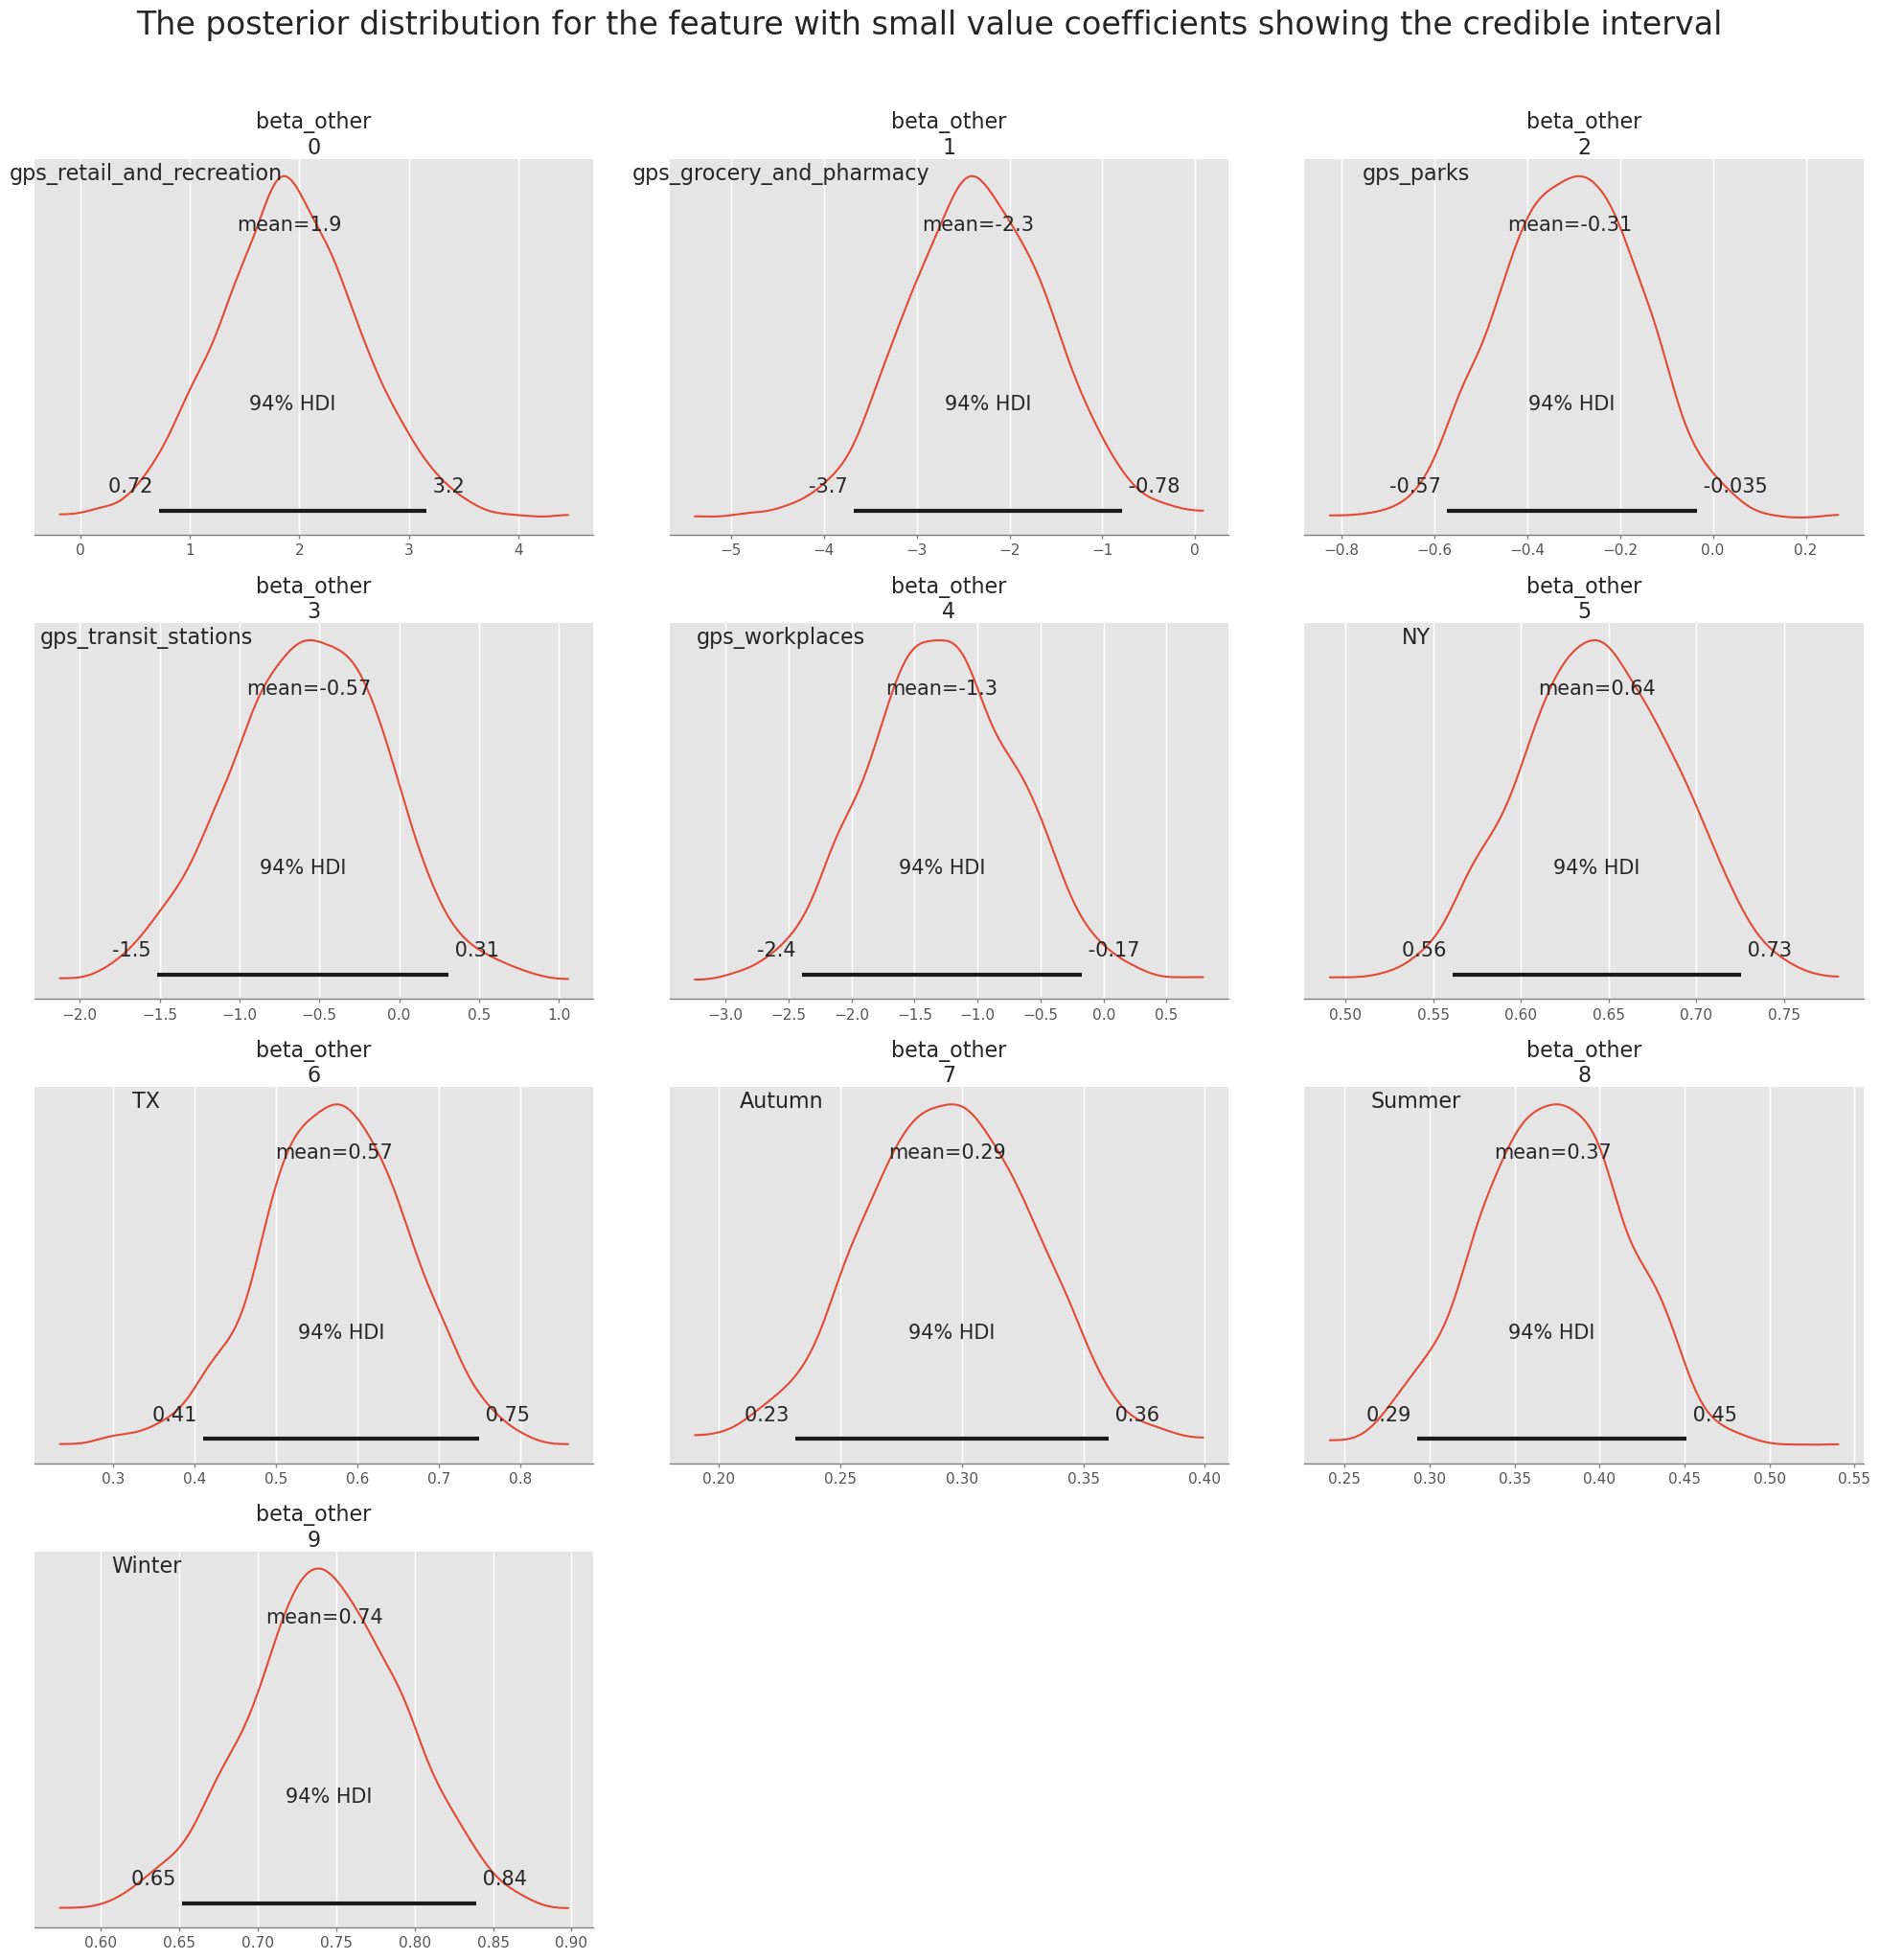

In [50]:
axes2 = avz.plot_posterior(trace, var_names='beta_other', kind='kde', figsize=(20,20))

# Set the subplot titles
titles2 = ['gps_retail_and_recreation', 'gps_grocery_and_pharmacy', 'gps_parks','gps_transit_stations', 'gps_workplaces', 'NY', 'TX', 'Autumn','Summer', 'Winter','','']
for i, ax in enumerate(axes2.flatten()):
    ax.text(0.2, 0.99, titles2[i], transform=ax.transAxes, ha='center', va='top',fontsize=16)
plt.suptitle("The posterior distribution for the feature with small value coefficients showing the credible interval", fontsize=24, y=1.02)
plt.tight_layout()

plt.show()

In [51]:
%%latex
\newpage

<IPython.core.display.Latex object>

# Research 1 Result

In [52]:
result_df = pd.DataFrame({"pred_frequentist": prediction_1.reset_index(drop=True), 
                          "pred_bayesian": pred_df["pred_mean"], 
                          "pred_random_forest": np.log(y_pred_rf),
                          "pred_decision_tree": np.log(y_pred_dt),
                          "observed": testy.reset_index(drop=True)['log_hospitalized_rate']})


In [53]:
result_df.head()
# Log_hospitalized_rate

,pred_frequentist,pred_bayesian,pred_random_forest,pred_decision_tree,observed
0,1.943022,1.968505,1.704268,1.837370,1.678964
1,2.217877,2.239932,2.382519,2.214846,2.187174
2,2.660890,2.656430,2.296297,2.290926,2.271094
3,2.501682,2.488457,2.519908,2.653242,2.533697
4,3.070967,3.069890,3.446118,3.572346,3.575151


In [54]:
rmse_df = pd.DataFrame({"Model": ["Frequentist", "Bayesian", "Random Forest", "Decision Tree"],
                        "rmse": [rmse_frequentist, rmse_bayesian, rmse_rf, rmse_dt]})
rmse_df

,Model,rmse
0,Frequentist,6.326717
1,Bayesian,6.301832
2,Random Forest,1.925693
3,Decision Tree,2.265319


In [55]:
%%latex
\newpage

<IPython.core.display.Latex object>

# Research Question 2

In [56]:
df = pd.read_csv("./df_q2.csv")
df.head()

,state,month_after_2020,hospitalized_rate,airline
0,AL,4,10.1,3010000.0
1,AL,5,12.9,8050000.0
2,AL,6,17.7,16530000.0
3,AL,7,43.0,24060000.0
4,AL,8,43.0,25830000.0


## Methods

1. Null hypothesis (H0): There is no significant association between hospitalization rate and airline traffic.
2. Alternative hypothesis (H1): There is a significant positive association between hospitalization rate and airline traffic.
3. Testing multiple hypotheses can provide a more comprehensive understanding of the data, increase the robustness of your conclusions, control for confounding variables, and potentially uncover new insights.

In [57]:
correlation_coefficient, p_value = stats.pearsonr(df['hospitalized_rate'], df['airline'])
p_value

1.0310351166685587e-08

In [58]:
p_values = df.groupby(["state"]).apply(lambda df: stats.pearsonr(df['hospitalized_rate'], df['airline'])[1])
rejects = p_values[p_values < 0.05]
print(len(rejects))
rejects

11


state
AZ    0.034052
CT    0.002183
DC    0.026175
IL    0.048737
LA    0.027373
MA    0.000759
MD    0.019537
ME    0.045679
NJ    0.032705
NY    0.011844
RI    0.000818
dtype: float64

Further examination shows that above 11 states have significant association between hospitalization rate and airline traffic.

In [59]:
accept = p_values[p_values >= 0.05]
print(len(accept))
accept

40


state
AK    0.116855
AL    0.344699
AR    0.461017
CA    0.072789
CO    0.769737
DE    0.343986
FL    0.749515
GA    0.155355
HI    0.085942
IA    0.332013
ID    0.350053
IN    0.378284
KS    0.609261
KY    0.799753
MI    0.342207
MN    0.665859
MO    0.947778
MS    0.080304
MT    0.762973
NC    0.818535
ND    0.660355
NE    0.195339
NH    0.871510
NM    0.413999
NV    0.104894
OH    0.901500
OK    0.472255
OR    0.051917
PA    0.259984
SC    0.395533
SD    0.340893
TN    0.920146
TX    0.302001
UT    0.994138
VA    0.295163
VT    0.167388
WA    0.177224
WI    0.608234
WV    0.487973
WY    0.668195
dtype: float64

And there is no significant association between hospitalization rate and airline traffic for the rest of the 40 states. (There are 50 states in the USA, the 51st state is DC)

In [60]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Control FWER and FDR

###  Bonferroni correction and Benjamini-Hochberg procedure

In [61]:
# FWER control using Bonferroni correction
reject_fwer, _, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')
discoveries_fwer = sum(reject_fwer)

# FDR control using Benjamini-Hochberg procedure
reject_fdr, _, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
discoveries_fdr = sum(reject_fdr)

print("Discoveries using FWER control:", discoveries_fwer)
print("Discoveries using FDR control:", discoveries_fdr)

Discoveries using FWER control: 2
Discoveries using FDR control: 3


Their are 11 rejections that were find in the p values and FWER made 2 dicoveries and FDR made 3 discoveries. Although Bonferroni correction tend to be more conservative, resulting in fewer discoveries, whereas FDR control methods like Benjamini-Hochberg procedure are generally more powerful, often leading to a higher number of discoveries. In our case both methods found fewer discoveries among the p values we found for different states.

In [62]:
%%latex
\newpage

<IPython.core.display.Latex object>

# Research 2 Result

1. The Bonferroni correction controls the Family-wise error rate (FWER). FWER is the probability of making at least one false positive (Type I error) across all hypothesis tests.
2. The Benjamini-Hochberg procedure controls the False Discovery Rate (FDR). FDR is the expected proportion of false positives among the rejected null hypotheses (discoveries).

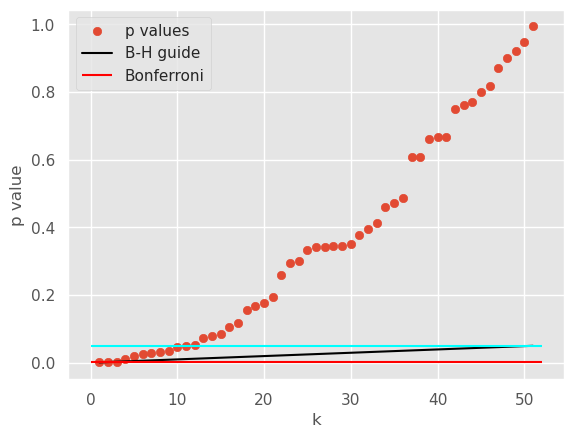

In [63]:
p_values = p_values.sort_values()
xs = np.array(range(1, len(p_values) + 1))
plt.scatter(xs, p_values, label = "p values")
plt.plot(xs, xs * 0.05 / 51, label = "B-H guide", color = "black")
plt.hlines(0.05, xmin = 0, xmax = len(p_values) + 1, color = "cyan")
plt.hlines(0.05 / 51, xmin = 0, xmax = len(p_values) + 1, label = "Bonferroni", color = "red")
plt.xlabel("k")
plt.ylabel("p value")
plt.legend();

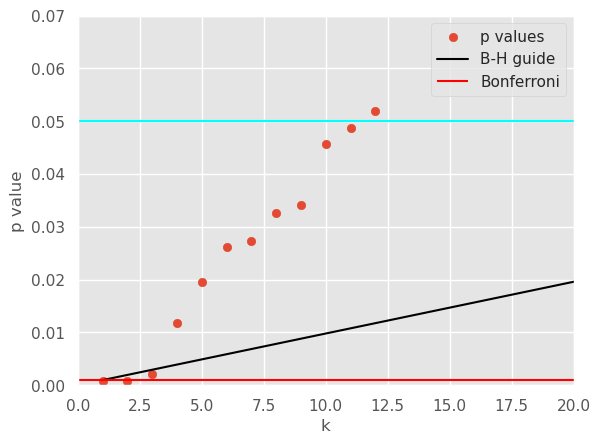

In [64]:
p_values = p_values.sort_values()
xs = np.array(range(1, len(p_values) + 1))
plt.scatter(xs, p_values, label = "p values")
plt.plot(xs, xs * 0.05 / 51, label = "B-H guide", color = "black")
plt.hlines(0.05, xmin = 0, xmax = len(p_values) + 1, color = "cyan")
plt.hlines(0.05 / 51, xmin = 0, xmax = len(p_values) + 1, label = "Bonferroni", color = "red")
plt.xlabel("k")
plt.ylabel("p value")
plt.axis([0, 20, 0, 0.07])
plt.legend();

In [65]:
%%latex
\newpage

<IPython.core.display.Latex object>